Valuable chnages
1. number of agents: changed from 100 to 20
2. simulation number can be changed at the end
3. number of expert: currently 1
4. conflict or not
5. spreading of expert or not
6. friends influence believe threshold = 0.6
7. expert is currently defined as the most connected

In [100]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pylab
import math
from networkx.generators.geometric import navigable_small_world_graph

from orderedset import OrderedSet

In [101]:
# %pylab inline

#-----------------------Simulating belief updates in a network----------------------------------------------#


class Patch:

    NEUTRAL = 'w'

    def __init__(self, id, status=None, pos=(0, 0)):
        if not status:
            self.status = Patch.NEUTRAL
        else:
            self.status = status
        self.pos = pos
        self.label = 'N'
        self.id = id
        self.degree = 0

    def set_belief(self, belief):
        self.status = belief

    def get_belief(self):
        return self.status

    def set_expert(self):
        self.label = 'E'

    def is_expert(self):
        return self.label == 'E'

    def get_size(self):
        if self.is_expert():
            return 1200
        return 600

    def __str__(self):
        if self.is_expert():
            return '%s%s(%s)' % (self.label, self.id, self.degree)
        return '%s%s' % (self.label, self.id)

    def __repr__(self):
        if self.is_expert():
            return '%s%s(%s)' % (self.label, self.id, self.degree)
        return '%s%s' % (self.label, self.id)

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, other):
        if not other:
            return False
        return self.id == other.id


class Belief(object):
    BELIEVE = 'b'
    DISBELIEVE = 'r'
    UNDECIDED = 'y'

    def __init__(self):
        self.believe_patches = set()
        self.disbelieve_patches = set()
        self.undecided_patches = set()

        self.belief_states = [Belief.BELIEVE, Belief.DISBELIEVE, Belief.UNDECIDED]

        self.belief_states_patches = {
            Belief.BELIEVE: self.believe_patches,
            Belief.DISBELIEVE: self.disbelieve_patches,
            Belief.UNDECIDED: self.undecided_patches
        }

    def set_belief(self, patch, state):
        if self.check_state(state):
            patch.set_belief(state)
            for belief_state in self.belief_states:
                if belief_state == state:
                    self.belief_states_patches[state].add(patch)
                elif patch in self.belief_states_patches[belief_state]:
                    self.belief_states_patches[belief_state].remove(patch)

    def get_belief(self, patch):
        for state in self.belief_states:
            if patch in self.belief_states_patches[state]:
                return state

    def check_state(self, state):
        if state not in [Belief.BELIEVE, Belief.DISBELIEVE, Belief.UNDECIDED]:
            return False
        return True


class Simulation(object):
    NR_PATCHES = 30   # Number of patches
    C_DISTANCE = 15  # An arbitrary parameter to determine which patches are connected
    NR_OF_EXPERTS = 1
    EXPERT_BELIEF = Belief.BELIEVE
    # this should be greater than 0.5 so that only one belief state can be above it at a time
    BELIEF_UPDATE_THRESHOLD = 0.6

    # these are used for generating the initial states of the patches
    INIT_BELIEVE_THRESHOLD = 0.8
    INIT_DISBELIEVE_THRESHOLD = 0.3

    # TODO: implement algorithm for generating small-world networks

    def __init__(self, nr_patches=NR_PATCHES,
                 nr_of_experts=NR_OF_EXPERTS,
                 expert_belief=Belief.BELIEVE,
                 belief_update_threshold=BELIEF_UPDATE_THRESHOLD,
                 init_believe_threshold=INIT_BELIEVE_THRESHOLD,
                 init_disbelieve_threshold=INIT_DISBELIEVE_THRESHOLD,
                 experts_spreading=True,
                 small_world_network=True,
                 conflict_and_coordination=True,
                 c_distance=C_DISTANCE):
        self.nr_patches = nr_patches
        self.nr_of_experts = nr_of_experts
        self.expert_belief = expert_belief
        self.belief_update_threshold = belief_update_threshold
        self.init_believe_threshold = init_believe_threshold
        self.init_disbelieve_threshold = init_disbelieve_threshold
        self.experts_spreading = experts_spreading
        self.small_world_network = small_world_network
        self.conflict_and_coordination = conflict_and_coordination
        self.c_distance = c_distance
        self.step = 0
        self.patches = []
        self.history = []
        self.experts = set()
        # this flag tells whether the draw_graph method should draw each node at node.pos
        # or disregard node.pos and let networkx figure out a way of calculating positions and
        # drawing the nodes
        self.draw_nodes_by_pos = True

        self.graph = nx.Graph()
        if self.small_world_network:
            self.generate_patches_2d_small_world()
        else:
            self.generate_patches_2d_random()

        self.belief = Belief()
        self.set_initial_beliefs()
        self.add_experts()

        # store a copy of the initial state of the graph
        self.initial_graph = self.graph.copy()

        self.save_history()

    def set_initial_beliefs(self):
        for patch in self.patches:
            self.set_random_belief(patch)

    def set_random_belief(self, patch):
        belief_random = np.random.uniform()
        if belief_random > self.init_believe_threshold:
            self.belief.set_belief(patch, Belief.BELIEVE)
        elif belief_random > self.init_disbelieve_threshold:
            self.belief.set_belief(patch, Belief.DISBELIEVE)
        else:
            self.belief.set_belief(patch, Belief.UNDECIDED)

    def generate_patches_2d_small_world(self):
        # I will generate a small world network graph using this tool from networkx
        # the problem is that I need a graph with Patch nodes while this gives me a graph
        # with tuple nodes, so I need to make a conversion
        #######Q-changed
        sw_graph = nx.barabasi_albert_graph(self.nr_patches, int(math.sqrt(self.nr_patches)))

        # will use this dict to later build the edges in my new graph
        sw_patches = {}
        i = 0
        for sw_node in sw_graph.nodes():
            i += 1
            patch = self.generate_patch(id=i, pos=sw_node)
            sw_patches[sw_node] = patch
            self.graph.add_node(patch)
            self.patches.append(patch)

        # now build the edges in our graph using the small world graph (sw_graph)
        for sw_node, patch in sw_patches.items():
            for sw_friend in sw_graph[sw_node]:
                friend_patch = sw_patches[sw_friend]
                self.graph.add_edge(patch, friend_patch)

        # now we need to generate the positions of the nodes on the image
        positions = nx.spring_layout(self.graph, scale=100)
        for node in self.graph:
            node.pos = positions[node]

        self.set_node_degrees()

    def generate_patches_2d_random(self):
        # maybe use some Barabasi-Albert graph instead of random generation?
        positions = np.random.uniform(high=100, size=(self.nr_patches, 2))
        # add patches to the graph
        for i in range(self.nr_patches):
            patch = self.generate_patch(id=i, pos=positions[i])
            self.graph.add_node(patch)
            self.patches.append(patch)
        # add edges
        for p1 in self.graph.nodes():
            for p2 in self.graph.nodes():
                if p1 == p2:
                    continue
                if self.distance_2d(p1, p2) <= self.c_distance:
                    self.graph.add_edge(p1, p2)

        self.set_node_degrees()

    def set_node_degrees(self):
        for patch in self.patches:
            patch.degree = len(self.graph[patch])

    def distance_2d(self, p1, p2):
        return np.sqrt((p1.pos[1]-p2.pos[1])**2+(p1.pos[0]-p2.pos[0])**2)

    def generate_patch(self, id, pos):
        return Patch(id=id, pos=pos)

    def add_experts(self):
        if self.conflict_and_coordination:
            self.add_experts_most_connected()
        else:
            self.add_experts_random()

    def add_experts_most_connected(self):
        most_connected = [(patch, self.get_degree(patch)) for patch in self.patches]
        most_connected.sort(key=lambda x: x[1], reverse=True)
        counter = 0
        for counter in range(self.nr_of_experts):
            patch, degree = most_connected[counter]
            self.add_expert(patch)

    def add_expert(self, patch):
        if not self.is_expert(patch):
            patch.set_expert()
            self.belief.set_belief(patch, self.expert_belief)
            self.experts.add(patch)

    def get_degree(self, patch):
        return len(self.graph[patch])

    def add_experts_random(self):
        for i in range(self.nr_of_experts):
            while True:
                patch = np.random.choice(self.patches)
                if not self.is_expert(patch):
                    patch.set_expert()
                    self.belief.set_belief(patch, self.expert_belief)
                    self.experts.add(patch)
                    break

    def set_expert(self, patch):
        patch.set_expert()
        self.belief.set_belief(patch, self.expert_belief)
        self.experts.add(patch)

    def is_expert(self, patch):
        return patch in self.experts

    def save_history(self):
        self.history.append({
            Belief.BELIEVE: len(self.belief.believe_patches),
            Belief.DISBELIEVE: len(self.belief.disbelieve_patches),
            Belief.UNDECIDED: len(self.belief.undecided_patches)})

    def draw_graph(self, graph=None):
        if graph is None:
            graph = self.graph
        pylab.figure(1, figsize=(14, 14))
        if self.draw_nodes_by_pos:
            positions = {patch: patch.pos for patch in graph.nodes()}
        else:
            positions = None
        nx.draw(graph, positions,
                with_labels=True,
                node_color=[patch.status for patch in graph.nodes()],
                node_size=[patch.get_size() for patch in graph.nodes()])
        pylab.show()

    def draw_initial_graph(self):
        self.draw_graph(self.initial_graph)

    def draw_history(self):
        time = range(1, len(self.history)+1)
        args = []
        for state in self.belief.belief_states:
            args.append(time)
            args.append([h[state] for h in self.history])
            args.append(state)
        kwargs = {'figure': pylab.figure(2, (8, 8))}
        pylab.plot(*args, **kwargs)
        pylab.show()

    def run_simulation(self, steps=1):
        for step in range(steps):
            for patch in self.patches:
                if self.conflict_and_coordination:
                    self.update_belief_coordination(patch)
                else:
                    self.update_belief(patch)
            self.save_history()

    def update_belief_coordination(self, patch):
        if self.is_expert(patch):  # the expert will not update its belief
            return

        # as suggested in the paper, if we have expert influence in conflicting with
        # friends influence, we'll go through a coordination process

        # in the first phase, the agent is influenced by the expert, if any around
        expert_influence, expert = self.get_expert_influence(patch)
        if expert_influence:
            self.belief.set_belief(patch, expert_influence)

        # but then if there is a conflict with the friends influence
        friends_influence = self.get_influence_above_threshold(patch)
        if expert_influence and friends_influence and expert_influence != friends_influence:
            # there will be a process of pair-wise coordination, as I understand from reading
            # the paper; this means we'll get the potential influence for each of the pair-groups
            # and compare it to the potential influence of the pair-group formed by the patch
            # and its expert neighbor
            expert_potential_influence = self.get_potential_influence([patch, expert])
            for friend in self.graph[patch]:
                if self.is_expert(friend) or self.belief.get_belief(friend) != friends_influence:
                    continue
                friends_potential_influence = self.get_potential_influence([patch, friend])
                if friends_potential_influence > expert_potential_influence:
                    self.belief.set_belief(patch, friends_influence)
        elif friends_influence and not expert_influence:
            self.belief.set_belief(patch, friends_influence)

    def get_potential_influence(self, group):
        # first add the nodes in the group to the potential
        potential = set(patch for patch in group)
        # then add the first degree neighbors
        for patch in group:
            for friend in self.graph[patch]:
                potential.add(friend)
        return len(potential)

    def update_belief(self, patch):
        if self.is_expert(patch):  # the expert will not update its belief
            return

        belief_state = self.belief.get_belief(patch)

        # if there is expert influence around, adopt the belief of the expert
        expert_influence, expert = self.get_expert_influence(patch)
        if expert_influence:
            if self.experts_spreading:
                # this flag means every agent that comes in contact with an expert will become
                # expert themselves - that's how it is in the paper but to me it looks unrealistic
                self.set_expert(patch)
            else:
                self.belief.set_belief(patch, expert_influence)
            return

        # if agent believes or disbelieves something, friends influence that is above the
        # BELIEF_UPDATE_THRESHOLD will make him become undecided
        # if he is undecided, friends influence above the BELIEF_UPDATE_THRESHOLD will make him
        # update his belief to either BELIEVE or DISBELIEVE
        relevant_influence = self.get_influence_above_threshold(patch)
        if belief_state == Belief.UNDECIDED and relevant_influence:
            self.belief.set_belief(patch, relevant_influence)
        elif relevant_influence and belief_state != relevant_influence:
            self.belief.set_belief(patch, Belief.UNDECIDED)

    def get_influence_above_threshold(self, patch):
        friends_influence = self.get_friends_influence(patch)
        for state in [Belief.BELIEVE, Belief.DISBELIEVE]:
            if friends_influence[state] >= self.belief_update_threshold:
                return state
        return None

    def get_expert_influence(self, patch):
        # for now all experts hold the same belief state, but maybe we want to change that in the future
        # so that experts do not all have the same belief state
        for friend in self.graph[patch]:
            if self.is_expert(friend):
                return (self.belief.get_belief(friend), friend)
        return (None, None)

    def get_friends_influence(self, patch):
        influence = {
            Belief.BELIEVE: 0,
            Belief.DISBELIEVE: 0,
        }
        total_friends = len(self.graph[patch])
        if total_friends == 0:  # who can influence him?
            return influence
        for friend in self.graph[patch]:
            state = self.belief.get_belief(friend)
            if state in [Belief.BELIEVE, Belief.DISBELIEVE]:
                influence[state] += 1
        for state in [Belief.BELIEVE, Belief.DISBELIEVE]:
            influence[state] = round(float(influence[state])/float(total_friends), 2)
        return influence

/Users/yunqixue/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/yunqixue/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/yunqixue/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/yunqixue/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

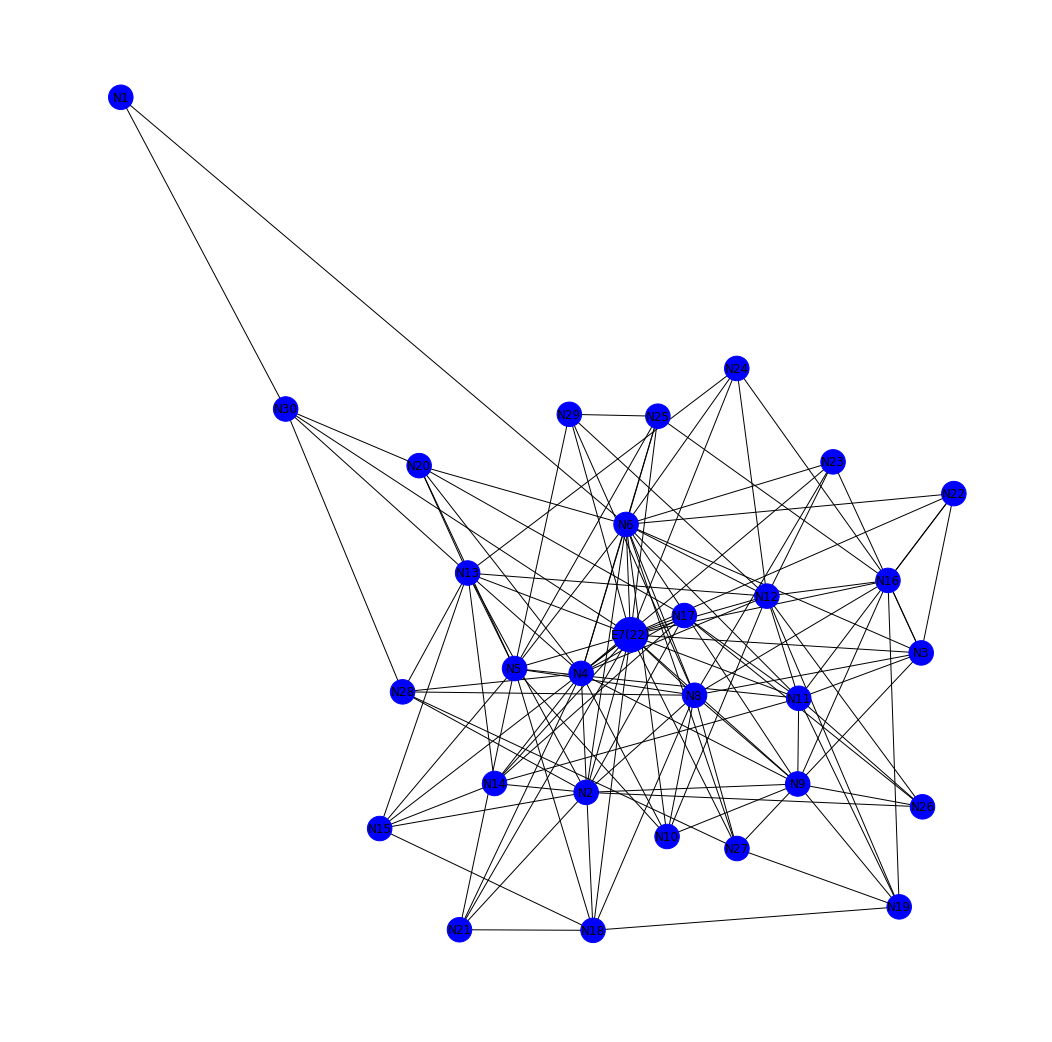

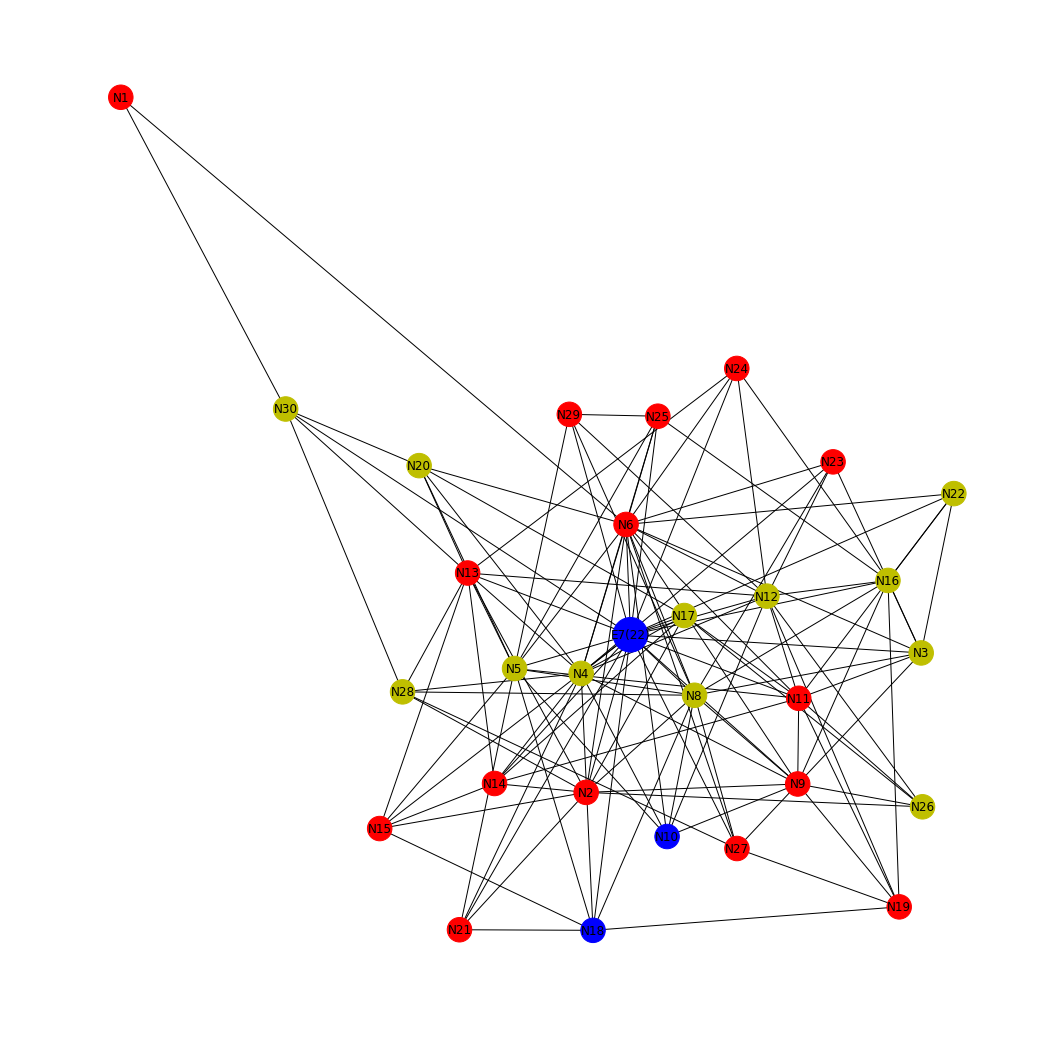

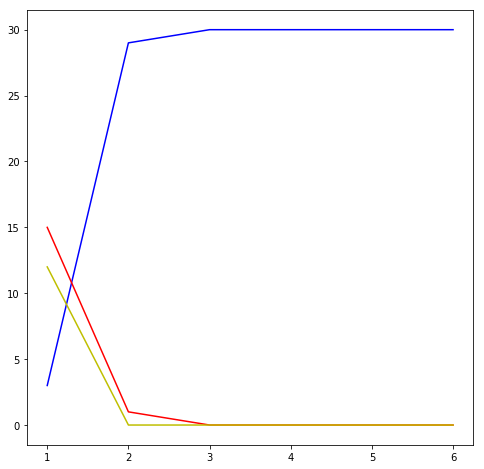

In [102]:
simulation = Simulation(nr_of_experts=1)
simulation.run_simulation(5)
simulation.draw_graph() 
simulation.draw_initial_graph()
simulation.draw_history()